<a href="https://colab.research.google.com/github/GawainGan/Machine-Learning-Engineering-for-Production-Specialization/blob/main/3-Machine%20Learning%20Modeling%20Pipelines%20in%20Production/W2/Note-EN/C3_W2_Lab_1_Manual_Dimensionality_EN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Manual Feature Engineering - EN
------------------------

Task: Perform feature engineering using TensorFlow and Keras.

By having a deeper understanding of the problem you are dealing with and proposing transformations to the raw features you will see how the predictive power of your model increases. In particular you will:


1. Define the model using feature columns.
2. Use Lambda layers to perform feature engineering on some of these features.
3. Compare the training history and predictions of the model before and after feature engineering.


First, install and import the necessary packages, set up paths to work on and download the dataset.

## Imports

In [ ]:
# Import the packages

# Utilities
import os
import logging

# For visualization
import matplotlib as mpl
import matplotlib.pyplot as plt
import pandas as pd

# For modelling
import tensorflow as tf
from tensorflow import feature_column as fc
from tensorflow.keras import layers, models

# Set TF logger to only print errors (dismiss warnings)
logging.getLogger("tensorflow").setLevel(logging.ERROR)

## Load taxifare dataset

For this lab you are going to use a tweaked version of the [Taxi Fare dataset](https://www.kaggle.com/c/new-york-city-taxi-fare-prediction/data), which has been pre-processed and split beforehand.

First, create the directory where the data is going to be saved.



In [ ]:
if not os.path.isdir("/tmp/data"):
    os.makedirs("/tmp/data")

Now download the data in `csv` format from a cloud storage bucket.

In [ ]:
!gsutil cp gs://cloud-training-demos/feat_eng/data/taxi*.csv /tmp/data

Copying gs://cloud-training-demos/feat_eng/data/taxi-test.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-train.csv...
Copying gs://cloud-training-demos/feat_eng/data/taxi-valid.csv...
/ [3 files][  5.3 MiB/  5.3 MiB]                                                
Operation completed over 3 objects/5.3 MiB.                                      


Let's check that the files were copied correctly and look like we expect them to.

In [ ]:
!ls -l /tmp/data/*.csv

-rw-r--r-- 1 root root 1113292 Mar 22 02:29 /tmp/data/taxi-test.csv
-rw-r--r-- 1 root root 3551735 Mar 22 02:29 /tmp/data/taxi-train.csv
-rw-r--r-- 1 root root  888648 Mar 22 02:29 /tmp/data/taxi-valid.csv


Everything looks fine. Notice that there are three files, one for each split of `training`, `testing` and `validation`.

## Inspect tha data

Now take a look at the training data.

In [ ]:
pd.read_csv('/tmp/data/taxi-train.csv').head()

,fare_amount,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,hourofday,dayofweek
0,8.1,1,-73.973731,40.791910,-73.962737,40.767318,14,4
1,4.5,2,-73.986495,40.739278,-73.986083,40.730933,10,6
2,2.9,1,-73.956043,40.772026,-73.956245,40.773934,22,3
3,7.0,1,-74.006557,40.705797,-73.980017,40.713617,6,3
4,6.5,1,-73.986443,40.741612,-73.990215,40.746467,10,2


The data contains a total of 8 variables.

The `fare_amount` is the target, the continuous value we’ll train a model to predict. This leaves you with 7 features.

However this lab is going to focus on transforming the geospatial ones so the time features `hourofday` and `dayofweek` will be ignored.

## Create an input pipeline

To load the data for the model you are going to use an experimental feature of Tensorflow that lets loading directly from a `csv` file.

For this you need to define some lists containing relevant information of the dataset such as the type of the columns.

In [ ]:
# Specify which column is the target
LABEL_COLUMN = 'fare_amount'

# Specify numerical columns
# Note you should create another list with STRING_COLS if you
# had text data but in this case all features are numerical
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude',
                'passenger_count', 'hourofday', 'dayofweek']


# A function to separate features and labels
def features_and_labels(row_data):
    label = row_data.pop(LABEL_COLUMN)
    return row_data, label


# A utility method to create a tf.data dataset from a CSV file
def load_dataset(pattern, batch_size=1, mode='eval'):
    dataset = tf.data.experimental.make_csv_dataset(pattern, batch_size)

    dataset = dataset.map(features_and_labels)  # features, label
    if mode == 'train':

        # If the mode is 'train', shuffle and repeat the dataset to facilitate randomness in batch selection
        # and an endless supply of data for training iterations.
        # 1000 is the shuffle buffer size, determining the number of samples in the dataset to randomly choose from
        # .repeat() ensures the dataset can be iteratively used for multiple epochs without running out of data
        dataset = dataset.shuffle(1000).repeat()

        # Use .prefetch method to prepare the next batch of data in advance, which can improve the efficiency of
        # data reading and reduce waiting time. The argument 1 indicates prefetching one batch at a time.
        # Take advantage of multi-threading; 1=AUTOTUNE
        dataset = dataset.prefetch(1)
    return dataset

You are about to create a simple Neural Network that takes numerical features as input. This input is represented by a [`DenseFeatures`](https://www.tensorflow.org/api_docs/python/tf/keras/layers/DenseFeatures) layer, which yields a dense Tensor based on the specified features. The network will include two dense layers with ReLU activation functions and an output layer with a linear activation function, suitable for a regression problem.

This model is uniquely structured because it is defined using feature columns, so the first layer might look different from what you might be used to. This is accomplished by setting up two dictionaries: one for the inputs, defined as Input layers, and another for the features, defined as feature columns.

The initial layer is constructed through feature columns, which may be a departure from your usual neural network setups.

Here are the steps to build this model:

- **Define the Input Layers**: Create an input layer for each numerical feature and organize these into a dictionary.
- **Define the Feature Columns**: For each numerical feature, create a corresponding numerical feature column, and gather these into another dictionary.
- **Build the DenseFeatures Layer**: Construct the DenseFeatures layer using the feature columns as parameters, then pass the input dictionary to this layer to produce a dense tensor.
- **Add Hidden Layers**: Following the DenseFeatures layer, add two hidden layers with 32 and 8 units respectively, utilizing ReLU activation functions.
- **Define the Output Layer**: Append an output layer with a linear activation function, as this setup is intended for a regression problem.
- **Create and Compile the Model**: Create the model using the specified input and output layers, then compile the model, choosing a loss function appropriate for regression problems (such as Mean Squared Error) and an optimizer (like Adam).

In [ ]:
def build_dnn_model():
    # input layer
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # feature_columns
    feature_columns = {
        colname: fc.numeric_column(colname)
        for colname in NUMERIC_COLS
    }

    # Constructor for DenseFeatures takes a list of numeric columns
    # and the resulting tensor takes a dictionary of Input layers
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(inputs)

    # two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    # Create model with inputs and output
    model = models.Model(inputs, output)

    # compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[
                      tf.keras.metrics.RootMeanSquaredError(name='rmse'),
                      'mse'
                  ])

    return model

We'll build our DNN model and inspect the model architecture.

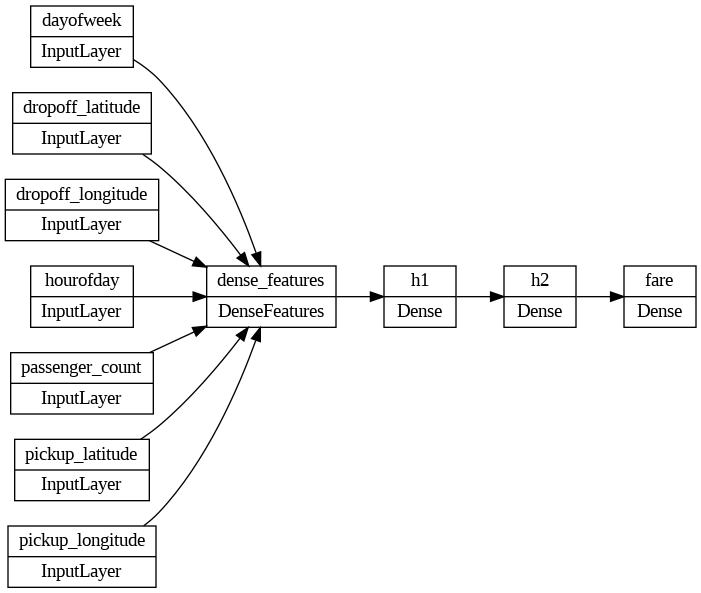

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model.png', show_shapes=False, rankdir='LR')

With the model architecture defined it is time to train it!

## Train the model

You are going to train the model for 20 epochs using a batch size of 32.

In [ ]:
NUM_EPOCHS = 20
TRAIN_BATCH_SIZE = 32
NUM_TRAIN_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-train.csv'))
NUM_EVAL_EXAMPLES = len(pd.read_csv('/tmp/data/taxi-valid.csv'))

print(f"training split has {NUM_TRAIN_EXAMPLES} examples\n")
print(f"evaluation split has {NUM_EVAL_EXAMPLES} examples\n")

training split has 59620 examples

evaluation split has 14905 examples



Use the previously defined function to load the datasets from the original csv files.

In [ ]:
# Training dataset
trainds = load_dataset('/tmp/data/taxi-train*', TRAIN_BATCH_SIZE, 'train')

# Evaluation dataset
evalds = load_dataset('/tmp/data/taxi-valid*', 1000, 'eval').take(NUM_EVAL_EXAMPLES//1000)

# Needs to be specified since the dataset is infinite
# This happens because the repeat method was used when creating the dataset
steps_per_epoch = NUM_TRAIN_EXAMPLES // TRAIN_BATCH_SIZE

# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20
1863/1863 [==============================] - 7s 3ms/step - loss: 107.3111 - rmse: 10.3591 - mse: 107.3111 - val_loss: 99.3924 - val_rmse: 9.9696 - val_mse: 99.3924
Epoch 2/20
1863/1863 [==============================] - 5s 2ms/step - loss: 101.5927 - rmse: 10.0793 - mse: 101.5927 - val_loss: 99.4261 - val_rmse: 9.9713 - val_mse: 99.4261
Epoch 3/20
1863/1863 [==============================] - 5s 3ms/step - loss: 102.8243 - rmse: 10.1402 - mse: 102.8243 - val_loss: 101.7736 - val_rmse: 10.0883 - val_mse: 101.7736
Epoch 4/20
1863/1863 [==============================] - 5s 3ms/step - loss: 104.4814 - rmse: 10.2216 - mse: 104.4814 - val_loss: 101.5376 - val_rmse: 10.0766 - val_mse: 101.5376
Epoch 5/20
1863/1863 [==============================] - 4s 2ms/step - loss: 101.0186 - rmse: 10.0508 - mse: 101.0186 - val_loss: 100.7781 - val_rmse: 10.0388 - val_mse: 100.7781
Epoch 6/20
1863/1863 [==============================] - 6s 3ms/step - loss: 103.1220 - rmse: 10.1549 - mse: 103.1220

### Visualize training curves

Now lets visualize the training history of the model with the raw features:

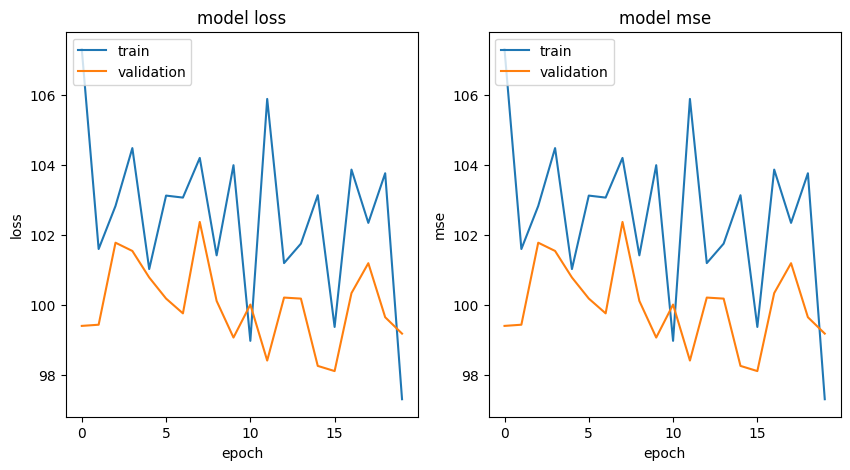

In [ ]:
# Function for plotting metrics for a given history
def plot_curves(history, metrics):
    nrows = 1
    ncols = 2
    fig = plt.figure(figsize=(10, 5))

    for idx, key in enumerate(metrics):
        ax = fig.add_subplot(nrows, ncols, idx+1)
        plt.plot(history.history[key])
        plt.plot(history.history[f'val_{key}'])
        plt.title(f'model {key}')
        plt.ylabel(key)
        plt.xlabel('epoch')
        plt.legend(['train', 'validation'], loc='upper left')


# Plot history metrics
plot_curves(history, ['loss', 'mse'])

The training history doesn't look very promising showing an erratic behaviour. Looks like the training process struggled to transverse the high dimensional space that the current features create.


Nevertheless let's use it for prediction.

Notice that the latitude and longitude values should revolve around (`37`, `45`) and (`-70`, `-78`) respectively since these are the range of coordinates for New York city.


**Explaination:**

- **erratic behaviour of training history**: In **high-dimensional spaces**, the model may experience what is known as "**dimensionality catastrophe**," where the representation of the data and the learning efficiency of the model decrease dramatically as the dimensionality increases, making it difficult for the model to learn an effective feature representation.

- **Range of latitude and longitude values**: it is mentioned here that the latitude and longitude values should be within a specific range, this is because our dataset or model application scenario may be limited to New York City. In Geographic Information Systems (GIS) and location data analytics, it is important to understand the **geographic extent of the data**, which helps us to assess the reasonableness and accuracy of the model predictions. **If the coordinates of the predictions are outside of New York City, then those predictions may be less reliable.**

In [ ]:
import warnings
warnings.filterwarnings('ignore')

In [ ]:
# Define a taxi ride (a data point)
taxi_ride = {
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
    'passenger_count': tf.convert_to_tensor([3.0]),
    'hourofday': tf.convert_to_tensor([3.0]),
    'dayofweek': tf.convert_to_tensor([3.0]),
}

# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)

# Print prediction
print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")

1/1 [==============================] - 0s 24ms/step
the model predicted a fare total of 12.30 USD for the ride.


The model predicted this particular ride to be around 12 USD. However you know the model performance is not the best as it was showcased by the training history. Let's improve it by using **Feature Engineering**.

## Improve Model Performance Using Feature Engineering

Going forward you will only use geo-spatial features as these are the most relevant when calculating the fare since this value is mostly dependant on the distance transversed:

In [ ]:
# Drop dayofweek and hourofday features
# 使用更少的特征值
NUMERIC_COLS = ['pickup_longitude', 'pickup_latitude',
                'dropoff_longitude', 'dropoff_latitude']

Since you are dealing exclusively with geospatial data you will create some transformations that are aware of this geospatial nature. This help the model make a better representation of the problem at hand.


For instance the model cannot magically understand what a coordinate is supposed to represent and since the data is taken from New York only, the latitude and longitude revolve around (`37`, `45`) and (`-70`, `-78`) respectively, which is arbitrary for the model. A good first step is to scale these values.


**Notice all transformations are created by defining functions**.

In [ ]:
def scale_longitude(lon_column):
    return (lon_column + 78)/8.

In [ ]:
def scale_latitude(lat_column):
    return (lat_column - 37)/8.

One pivotal insight to recognize is that the **fare charged** for a taxi ride correlates strongly with the **ride's distance**. However, the current data **features** provided to the model do not clearly communicate this relationship. Specifically, the model does not have the capacity to infer that the **coordinates** (`pickup_latitude`, `pickup_longitude`) signify the location where the passenger's journey commenced, nor does it comprehend that (`dropoff_latitude`, `dropoff_longitude`) indicates the journey's termination point. Most critically, the model lacks the understanding that the **fare** is intimately linked to the **distance traversed** between these two sets of coordinates.

To rectify this gap in the model's knowledge, it is necessary to engineer a new **feature** that embodies this **distance information** explicitly. This can be achieved by computing a transformation of the **latitude and longitude coordinates**. We could calculate a **distance metric**—such as the **Euclidean distance**, which is a straight-line distance between two points in Euclidean space, or the **Haversine formula**, which factors in the Earth's curvature for more accuracy when measuring the distance over the globe.

By incorporating this new **distance feature**, we empower the model with the ability to leverage this crucial piece of information, thereby significantly enhancing its **predictive prowess** in estimating **taxi fares**. This transformation effectively bridges the understanding between the **geographical data points** and the **fare costs**, a connection that is fundamental for accurate fare predictions.

In [ ]:
def euclidean(params):
    lon1, lat1, lon2, lat2 = params
    londiff = lon2 - lon1
    latdiff = lat2 - lat1
    return tf.sqrt(londiff*londiff + latdiff*latdiff)

### Applying transformations

Now you will define the `transform` function which will apply the previously defined transformation functions. To apply the actual transformations you will be using `Lambda` layers apply a function to values (in this case the inputs).


In [ ]:
def transform(inputs, numeric_cols):

    # Make a copy of the inputs to apply the transformations to
    transformed = inputs.copy()

    # Define feature columns
    feature_columns = {
        colname: tf.feature_column.numeric_column(colname)
        for colname in numeric_cols
    }

    # Scaling longitude from range [-70, -78] to [0, 1]
    for lon_col in ['pickup_longitude', 'dropoff_longitude']:
        transformed[lon_col] = layers.Lambda(
            scale_longitude,
            name=f"scale_{lon_col}")(inputs[lon_col])

    # Scaling latitude from range [37, 45] to [0, 1]
    for lat_col in ['pickup_latitude', 'dropoff_latitude']:
        transformed[lat_col] = layers.Lambda(
            scale_latitude,
            name=f'scale_{lat_col}')(inputs[lat_col])

    # add Euclidean distance
    transformed['euclidean'] = layers.Lambda(
        euclidean,
        name='euclidean')([inputs['pickup_longitude'],
                           inputs['pickup_latitude'],
                           inputs['dropoff_longitude'],
                           inputs['dropoff_latitude']])


    # Add euclidean distance to feature columns
    feature_columns['euclidean'] = fc.numeric_column('euclidean')

    return transformed, feature_columns

In [ ]:
# simulating the data of both longitude and latitude where taxi drop out
taxi_ride_drop_out = {
    'pickup_longitude': tf.convert_to_tensor([-73.982683]),
    'pickup_latitude': tf.convert_to_tensor([40.742104]),
    'dropoff_longitude': tf.convert_to_tensor([-73.983766]),
    'dropoff_latitude': tf.convert_to_tensor([40.755174]),
}

# function transform(): transform into euclidean distance
transformed_taxi_ride = transform(taxi_ride_drop_out, [])
# return all data that processed in the transform() function
# it also included the transformed "euclidean" value at the end
transformed_taxi_ride

({'pickup_longitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.50216484], dtype=float32)>,
  'pickup_latitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.46776295], dtype=float32)>,
  'dropoff_longitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.5020294], dtype=float32)>,
  'dropoff_latitude': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.4693966], dtype=float32)>,
  'euclidean': <tf.Tensor: shape=(1,), dtype=float32, numpy=array([0.01311398], dtype=float32)>},
 {'euclidean': NumericColumn(key='euclidean', shape=(1,), default_value=None, dtype=tf.float32, normalizer_fn=None)})

In [ ]:
print("The transformed value of the euclidiean is:", transformed_taxi_ride[0]['euclidean'].numpy()[0])

The transformed value of the euclidiean is: 0.013113979


## Update the model

Next, you'll create the DNN model now with the engineered (transformed) features.

In [ ]:
def build_dnn_model():

    # input layer (notice type of float32 since features are numeric)
    inputs = {
        colname: layers.Input(name=colname, shape=(), dtype='float32')
        for colname in NUMERIC_COLS
    }

    # transformed features
    transformed, feature_columns = transform(inputs, numeric_cols=NUMERIC_COLS)

    # Constructor for DenseFeatures takes a list of numeric columns
    # and the resulting tensor takes a dictionary of Lambda layers
    dnn_inputs = layers.DenseFeatures(feature_columns.values())(transformed)

    # two hidden layers of 32 and 8 units, respectively
    h1 = layers.Dense(32, activation='relu', name='h1')(dnn_inputs)
    h2 = layers.Dense(8, activation='relu', name='h2')(h1)

    # final output is a linear activation because this is a regression problem
    output = layers.Dense(1, activation='linear', name='fare')(h2)

    # Create model with inputs and output
    model = models.Model(inputs, output)

    # Compile model (Mean Squared Error is suitable for regression)
    model.compile(optimizer='adam',
                  loss='mse',
                  metrics=[tf.keras.metrics.RootMeanSquaredError(name='rmse'), 'mse'])

    return model

In [ ]:
# Save compiled model into a variable
model = build_dnn_model()

Let's see how the model architecture has changed.

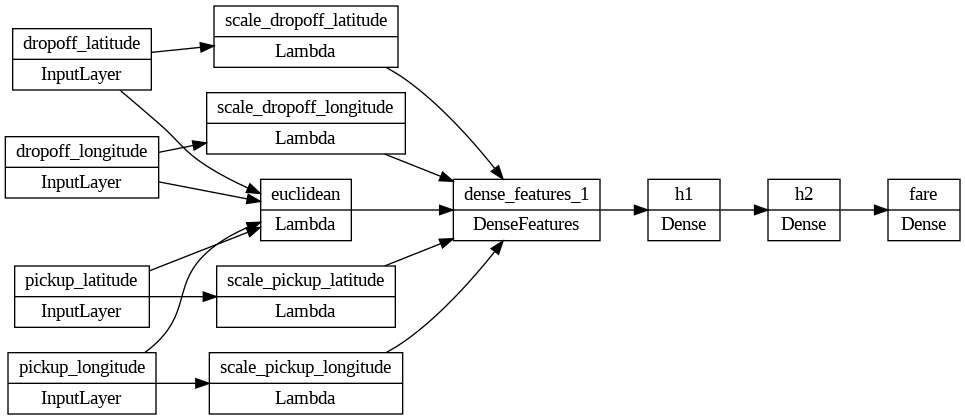

In [ ]:
# Plot the layer architecture and relationship between input features
tf.keras.utils.plot_model(model, 'dnn_model_engineered.png', show_shapes=False, rankdir='LR')

This plot is very useful for understanding the relationships and dependencies between the original and the transformed features!

**Notice that the input of the model now consists of 5 features instead of the original 7, thus reducing the dimensionality of the problem.**

Let's now train the model that includes feature engineering.

In [ ]:
# Train the model and save the history
history = model.fit(trainds,
                    validation_data=evalds,
                    epochs=NUM_EPOCHS,
                    steps_per_epoch=steps_per_epoch)

Epoch 1/20
1863/1863 [==============================] - 7s 3ms/step - loss: 113.4976 - rmse: 10.6535 - mse: 113.4976 - val_loss: 84.2518 - val_rmse: 9.1789 - val_mse: 84.2518
Epoch 2/20
1863/1863 [==============================] - 4s 2ms/step - loss: 68.0406 - rmse: 8.2487 - mse: 68.0406 - val_loss: 54.3633 - val_rmse: 7.3731 - val_mse: 54.3633
Epoch 3/20
1863/1863 [==============================] - 5s 3ms/step - loss: 45.7989 - rmse: 6.7675 - mse: 45.7989 - val_loss: 43.3640 - val_rmse: 6.5851 - val_mse: 43.3640
Epoch 4/20
1863/1863 [==============================] - 5s 3ms/step - loss: 49.6334 - rmse: 7.0451 - mse: 49.6334 - val_loss: 38.9198 - val_rmse: 6.2386 - val_mse: 38.9198
Epoch 5/20
1863/1863 [==============================] - 5s 3ms/step - loss: 41.7801 - rmse: 6.4638 - mse: 41.7801 - val_loss: 39.0501 - val_rmse: 6.2490 - val_mse: 39.0501
Epoch 6/20
1863/1863 [==============================] - 6s 3ms/step - loss: 39.9866 - rmse: 6.3235 - mse: 39.9866 - val_loss: 37.4564 - v

Notice that the features `passenger_count`, `hourofday` and `dayofweek` were excluded since they were omitted when defining the input pipeline.

Now lets visualize the training history of the model with the engineered features.

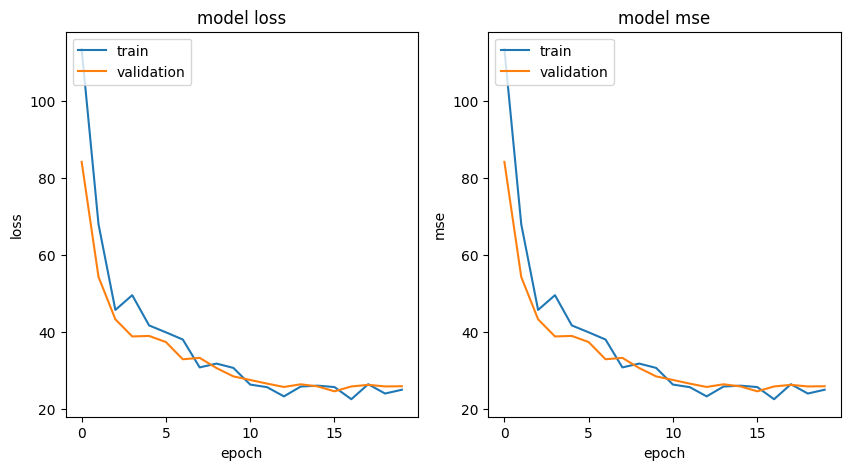

In [ ]:
# Plot history metrics
plot_curves(history, ['loss', 'mse'])

This looks a lot better than the previous training history! Now the loss and error metrics are decreasing with each epoch and both curves (train and validation) are very close to each other. Nice job!

Let's do a prediction with this new model on the example we previously used.

In [ ]:
# Use the model to predict
prediction = model.predict(taxi_ride, steps=1)

# Print prediction
print(f"the model predicted a fare total of {float(prediction):.2f} USD for the ride.")

1/1 [==============================] - 0s 146ms/step
the model predicted a fare total of 6.51 USD for the ride.


Wow, now the model predicts a fare that is roughly half of what the previous model predicted! Looks like the model with the raw features was overestimating the fare by a great margin.

Notice that you get a warning since the `taxi_ride` dictionary contains information about the unused features. You can supress it by redefining `taxi_ride` without these values but it is useful to know that Keras is smart enough to handle it on its own.